# Python Multi-Threading vs Multi-Processing

There is a library called [threading](https://docs.python.org/2/library/threading.html) in Python and it uses threads (rather than just processes) to implement parallelism.  This may be surprising news if you know about the Python's [Global Interpreter Lock](https://en.wikipedia.org/wiki/Global_interpreter_lock) or GIL but it actually works well for certain instances without violating the GIL.  And this is all done without any overhead -- simply define functions that make I/O requests and the system will handle the rest.

## Global Interpreter Lock
First, let's explain what GIL is.  The Global Interpreter Lock reduces the usefulness of threads in Python (more precisely [CPython](https://en.wikipedia.org/wiki/CPython)) by allowing only one native thread to execute at a time.  This made implementing Python easier to implement in the (usually thread-unsafe) C libraries and can increase the execution speed of single-threaded programs.  However, it remains controvertial because it prevents true lightweight parallelism.  You can achieve parallelism, but it requires using multi-processing, which is implemented by the eponymous library [multiprocessing](https://docs.python.org/2/library/multiprocessing.html).  Instead of spinning up threads, this library uses processes, which bypasses the GIL.

It may appear that the GIL would kill Python multithreading but not quite.  In general, there are two main use cases for multithreading:

1. To take advantage of multiple cores on a single machine
2. To take advantage of I/O latency to process other threads

In general, we cannot benefit from (1) with threading but we can benefit from (2).  

## MultiProcessing
The general `threading` library is fairly low-level but it turns out that `multiprocessing` wraps this in `multiprocessing.pool.ThreadPool`, which conveniently takes on the same interface as `multiprocessing.pool.Pool`.

One benefit of using `threading` is that it avoids pickling.  Multi-processing relies on pickling objects in memory to send to other processes.  For example, if the `timed` decorator did not `wraps` the `wrapper` function it returned, then CPython would be able to pickle our functions `request_func` and `selenium_func` and hence these could not be multi-processed. In contrast, the `threading` library, even through `multiprocessing.pool.ThreadPool` works just fine.  Multiprocessing also requires more ram and startup overhead.

## Analysis
We analyze the highly I/O dependent task of making 100 URL requests for random wikipedia pages.  We compare:

1. The Python [requests](http://docs.python-requests.org/en/master/) module and
2. The Python [selenium](https://www.seleniumhq.org/) with [PhantomJS](http://phantomjs.org/).

We run each of these requests in three ways and measure the time required for each fetch:

1. In serial
2. In parallel in a  `threading` pool with 10 threads
3. In parallel in a  `multiprocessing` pool with 10 threads

Each request is timed and we compare the results.

## Results
Firstly, the per-thread running time for `requests` is obviously lower than for `selenium`, as the latter requires spinning up a new process to run a `PhantomJS` headless browser.  It's also interesting to notice that the individual threads (particularly selenium threads) run faster in serial than in parallel, which is the typical bandwidth vs. latency tradeoff.  In particular, selenium threads are more than twice as slow, problably because of resource contention with 10 selenium processes spinning up at once.

[

Likewise, all threads run roughly 4 times faster for `selenium` requests and roughly 8 times faster for `requests` requests when multithreaded compared with serial.

There was no significant performance difference between using `threading` vs `multiprocessing`.

## Conclusion
The performance between multithreading and multiprocessing are extremely similar and the exact performance details are likely to depend on your specific application.  Threading through `multiprocessing.pool.ThreadPool` is really easy, or at least as easy as using the  `multiprocessing.pool.Pool` interface -- simply define your I/O workloads as a function and use the `ThreadPool` to run them in parallel.

**Improvements welcome!**  Please submit a pull request to [our github](https://github.com/tianhuil/python-multi-benchmark).

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

import pandas as pd
import numpy as np

In [2]:
df = pd.read_json("../results/result-2018-03-17T20:41:48.json", lines=True)
df["time"] = df["end"] - df["start"]
df.head()

,end,func,i,length,parallel,start,time
0,1.521334e+09,request_func,0,23748,multiprocess,1.521334e+09,0.367852
1,1.521334e+09,request_func,1,39305,multiprocess,1.521334e+09,0.244528
2,1.521334e+09,request_func,2,71392,multiprocess,1.521334e+09,0.144929
3,1.521334e+09,request_func,3,23619,multiprocess,1.521334e+09,0.291267
4,1.521334e+09,request_func,4,75484,multiprocess,1.521334e+09,0.242605


parallel,multiprocess,multithread,serial
func,,,
request_func,0.243113,0.290684,0.232780
selenium_func,3.807168,3.765601,1.608267


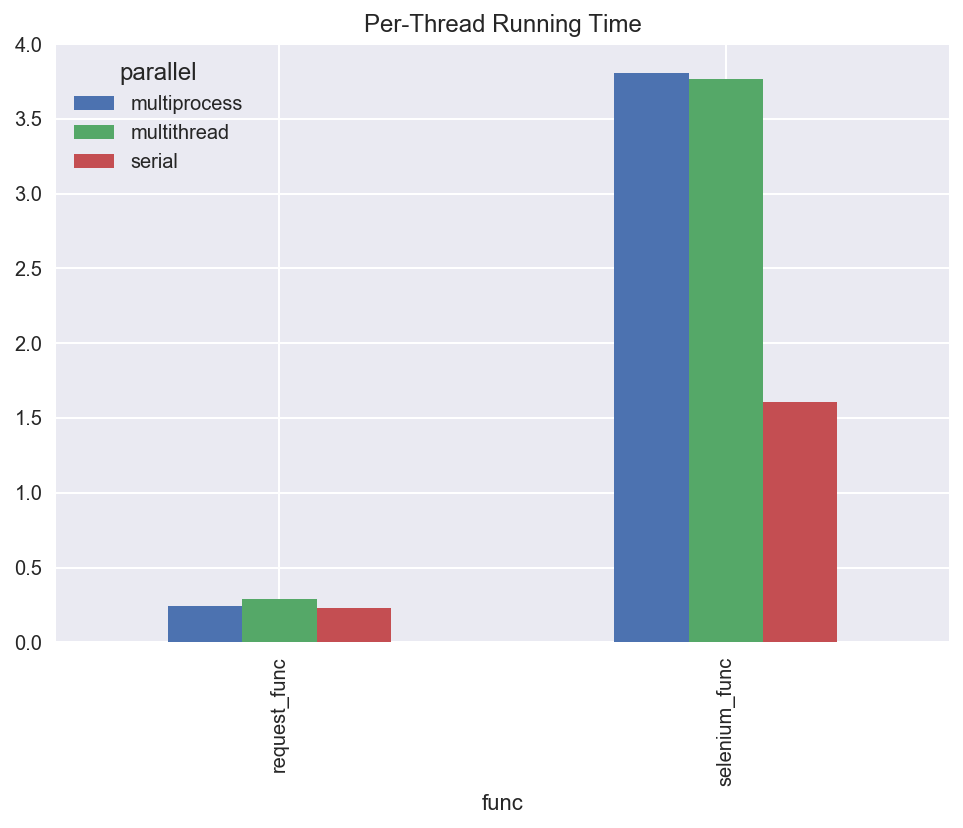

In [3]:
results = df.groupby(["func", "parallel"])["time"].mean().unstack()
results.plot(kind='bar')
plt.title("Per-Thread Running Time")
results

parallel,multiprocess,multithread,serial
func,,,
request_func,2.823964,3.088014,23.278413
selenium_func,42.579427,40.966607,160.828109


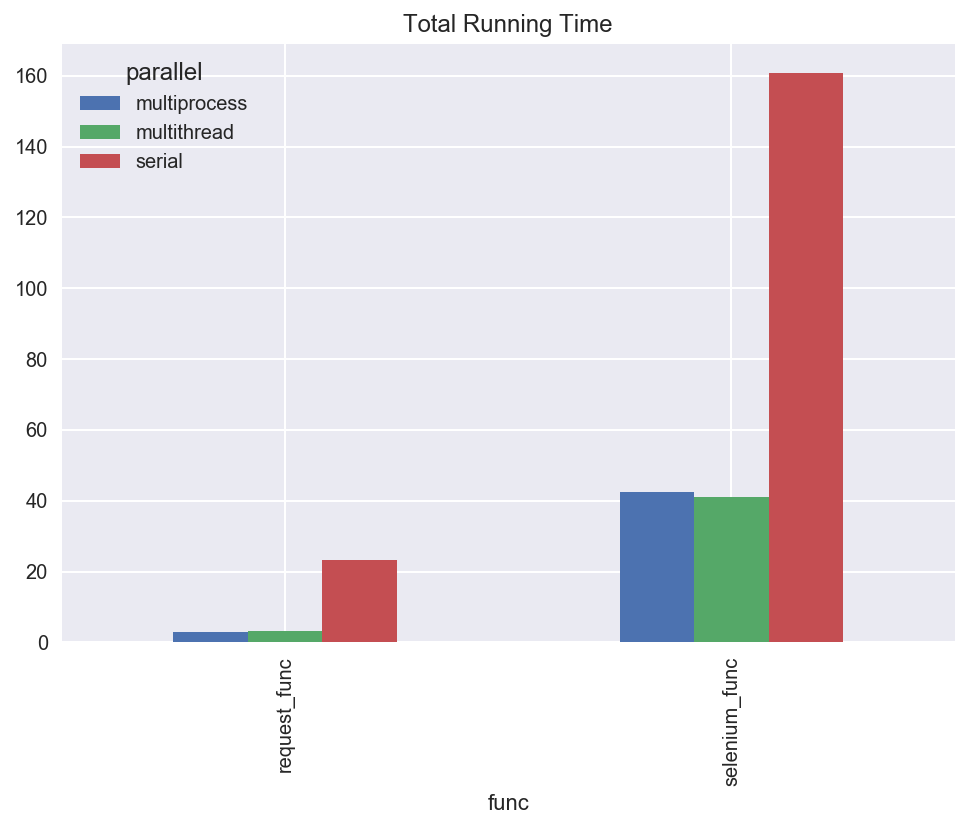

In [4]:
df_total_time = df.groupby(["func", "parallel"]).aggregate({"start": np.min, "end": np.max})
results = (df_total_time["end"] - df_total_time["start"]).unstack()
results.plot(kind="bar")
plt.title("Total Running Time")
results